In [2]:
# Loading

import pandas as pd
df_combined = pd.read_parquet('parquets/house5/df_combined1') # Choose Paquet

<h3><center><b>CNN</b></center></h3>
<hr>

In [3]:
# trimming for full days, need for windowing
import pandas as pd

def trim_data_to_full_days(data):
    if not isinstance(data.index, pd.DatetimeIndex):
        if 'timestamp' in data.columns:
            data['timestamp'] = pd.to_datetime(data['timestamp'])
            data.set_index('timestamp', inplace=True)
        else:
            raise ValueError("Dataframe must have a 'timestamp' column or DatetimeIndex.")

    data = data.sort_index()
    first_full_day = data.index.ceil('D')[0]
    last_full_day = data.index.floor('D')[-1]

    trimmed_data = data[first_full_day:last_full_day]
    return trimmed_data

df_combined = trim_data_to_full_days(df_combined)

In [4]:
for col in df_combined.columns:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')

In [5]:
X = df_combined[['what_hour', 'what_day', 'is_weekend', 'aggregate', 'agg_clustered']]

Y_columns = df_combined.columns.difference(X.columns)
Y = df_combined[Y_columns]

In [6]:
# one-hot encoding
# Choose columns / devices for training

columns_to_encode = [ 'hairdryer', '24_inch_lcd_bedroom', 'kettle', 'oven', 'dishwasher', 'washer_dryer'] # house5

# columns_to_encode = ['kettle', 'rice_cooker', 'washing_machine', 'dish_washer', 'microwave', 'toaster'] # house2

Y= pd.get_dummies(Y, columns=columns_to_encode)
Y = Y.astype(int)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled= scaler.fit_transform(X) # normalizing input

In [8]:
import numpy as np

def sliding_window(data, size, step):
    num_windows = 1 + (len(data) - size) // step
    windows = [data[i * step:i * step + size] for i in range(num_windows)]
    return np.array(windows)


window_size = 60
step_size = 30

X_windowed = sliding_window(X_scaled, window_size, step_size)
Y_windowed = sliding_window(Y, window_size, step_size)

print(X_windowed.shape)
print(Y_windowed.shape)

(6527, 60, 5)
(6527, 60, 22)


In [9]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train_val, X_test = train_test_split(X_windowed, test_size=0.15, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.15/0.85, random_state=42)

Y_train_val, Y_test = train_test_split(Y_windowed, test_size=0.15, random_state=42)
Y_train, Y_val = train_test_split(Y_train_val, test_size=0.15/0.85, random_state=42)

In [10]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_val shape: {Y_val.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (4568, 60, 5)
X_val shape: (979, 60, 5)
X_test shape: (980, 60, 5)
Y_train shape: (4568, 60, 22)
Y_val shape: (979, 60, 22)
Y_test shape: (980, 60, 22)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed

input_shape = (window_size, 5)

model = Sequential([

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    Dropout(0.3),
    
    Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    Dropout(0.3),

    TimeDistributed(Flatten()),

    TimeDistributed(Dense(64, activation='relu')),
    Dropout(0.5),

    TimeDistributed(Dense(Y_train.shape[-1], activation='softmax'))
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=30, validation_data=(X_val, Y_val), batch_size=32)



Epoch 1/30


143/143 [==============================] - 6s 26ms/step - loss: 0.5846 - accuracy: 0.1747 - val_loss: 0.5147 - val_accuracy: 0.8547
Epoch 2/30
143/143 [==============================] - 3s 24ms/step - loss: 0.5177 - accuracy: 0.1527 - val_loss: 0.5067 - val_accuracy: 0.7946
Epoch 3/30
143/143 [==============================] - 3s 22ms/step - loss: 0.5085 - accuracy: 0.1290 - val_loss: 0.5032 - val_accuracy: 0.1073
Epoch 4/30
143/143 [==============================] - 3s 24ms/step - loss: 0.5061 - accuracy: 0.1890 - val_loss: 0.5014 - val_accuracy: 0.2037
Epoch 5/30
143/143 [==============================] - 3s 24ms/step - loss: 0.5048 - accuracy: 0.2310 - val_loss: 0.5002 - val_accuracy: 0.3599
Epoch 6/30
143/143 [==============================] - 3s 23ms/step - loss: 0.5038 - accuracy: 0.3018 - val_loss: 0.4993 - val_accuracy: 0.3956
Epoch 7/30
143/143 [==============================] - 4s 29ms/step - loss: 0.5029 - accuracy: 0.2727 - val_loss: 0.4987 - val_accuracy: 0.

In [12]:
predictions = model.predict(X_test)

# threshold of 0.5 to convert probabilities to binary outputs
y_pred = (predictions > 0.5).astype(int)

31/31 [==============================] - 0s 6ms/step


In [13]:
# Convert predictions to a DataFrame
y_pred_df = pd.DataFrame(y_pred.reshape(y_pred.shape[0] * y_pred.shape[1], y_pred.shape[2]), columns=Y.columns)
Y_test_df = pd.DataFrame(Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], Y_test.shape[2]), columns=Y.columns)

def reverse_one_hot(df):
    result = pd.DataFrame()
    for col in df.columns:
        if '_0' in col:
            base_col = col.rsplit('_', 1)[0]
            one_hot_df = df.filter(like=base_col)
            result[base_col] = one_hot_df.idxmax(axis=1).apply(lambda x: int(x.rsplit('_', 1)[1]))
    return result

# Reverse one-hot encoding
y_pred = reverse_one_hot(y_pred_df)
Y_test = reverse_one_hot(Y_test_df)

Y_test.columns=columns_to_encode
y_pred.columns=columns_to_encode

In [14]:
Y_test_np = Y_test.to_numpy().astype(int)
y_pred_np = y_pred.to_numpy().astype(int)

def exact_match_accuracy(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    exact_matches = np.all(true == pred, axis=1)
    accuracy = np.mean(exact_matches)
    return accuracy

# accuracy
exact_accuracy = exact_match_accuracy(Y_test_np, y_pred_np)
print(f"Exact Match Accuracy: {exact_accuracy:.2%}")

mismatches = Y_test_np != y_pred_np
hamming_losses = mismatches.mean(axis=0)
hamming_accuracies = 1 - hamming_losses

# Hamming accuracy for each label
for i, accuracy in enumerate(hamming_accuracies):
    print(f"Hamming Accuracy for Label {i+1} ({Y_test.columns[i]}): {accuracy:.2%}")

# overall Hamming accuracy
overall_hamming_accuracy = 1 - np.mean(hamming_losses)
print(f"Overall Hamming Accuracy: {overall_hamming_accuracy:.2%}")

Exact Match Accuracy: 88.45%
Hamming Accuracy for Label 1 (hairdryer): 99.82%
Hamming Accuracy for Label 2 (24_inch_lcd_bedroom): 96.33%
Hamming Accuracy for Label 3 (kettle): 99.82%
Hamming Accuracy for Label 4 (oven): 98.09%
Hamming Accuracy for Label 5 (dishwasher): 97.78%
Hamming Accuracy for Label 6 (washer_dryer): 95.61%
Overall Hamming Accuracy: 97.91%


In [15]:
from sklearn.metrics import classification_report

print("Classification Report for each target:")
for column in Y_test.columns:
    print(f"\nClassification Report for {column}:")
    print(classification_report(Y_test[column], y_pred[column], zero_division=0))

Classification Report for each target:

Classification Report for hairdryer:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58693
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00       103

    accuracy                           1.00     58800
   macro avg       0.33      0.33      0.33     58800
weighted avg       1.00      1.00      1.00     58800


Classification Report for 24_inch_lcd_bedroom:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56641
           1       0.00      0.00      0.00      2159

    accuracy                           0.96     58800
   macro avg       0.48      0.50      0.49     58800
weighted avg       0.93      0.96      0.95     58800


Classification Report for kettle:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58693
           1       0.00

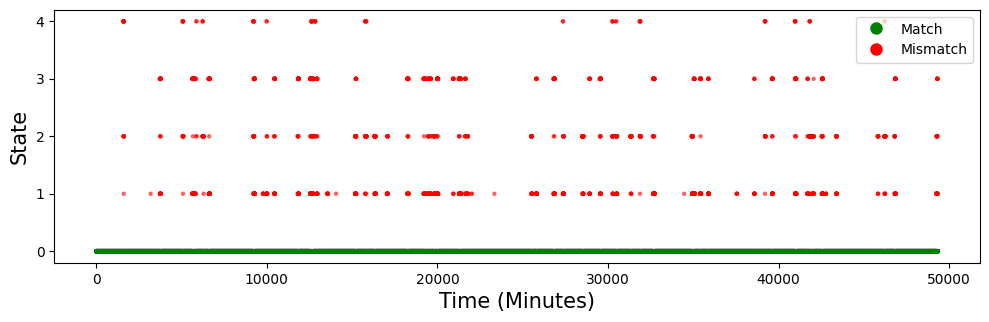

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

#  Choose device number for visualization
device = 5
n_samples =  49345

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
y_pred = pd.DataFrame(y_pred)

colors = np.array(['green' if int(a) == int(b) else 'red' for a, b in zip(y_pred.iloc[:n_samples, device], Y_test.iloc[:n_samples, device])])

x_indices = Y_test.index[:n_samples]

scatter = plt.scatter(x_indices, Y_test.iloc[:n_samples, device].astype(int),
                      c=colors, alpha=0.5, s=5)

plt.yticks(np.arange(min(Y_test.iloc[:n_samples, device].astype(int)), max(Y_test.iloc[:n_samples, device].astype(int)) + 1))

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Match',
                          markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Mismatch',
                          markerfacecolor='red', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')

plt.ylabel('State', fontsize=15)
plt.xlabel('Time (Minutes)', fontsize=15)

plt.tight_layout()
plt.show()

### Diagram for CNN architecture

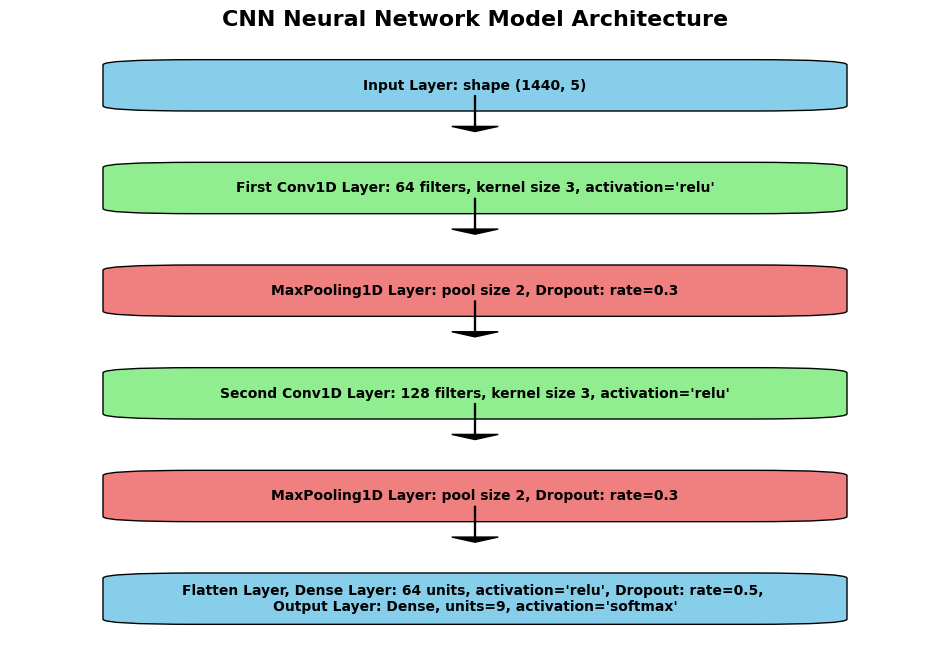

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(12, 8))

layer_y_positions = [10, 8, 6, 4, 2, 0]
layer_labels = [
    "Input Layer: shape (1440, 5)",
    "First Conv1D Layer: 64 filters, kernel size 3, activation='relu'",
    "MaxPooling1D Layer: pool size 2, Dropout: rate=0.3",
    "Second Conv1D Layer: 128 filters, kernel size 3, activation='relu'",
    "MaxPooling1D Layer: pool size 2, Dropout: rate=0.3",
    "Flatten Layer, Dense Layer: 64 units, activation='relu', Dropout: rate=0.5, \nOutput Layer: Dense, units=9, activation='softmax'"
]

colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightgreen', 'lightcoral', 'skyblue']

for y, label, color in zip(layer_y_positions, layer_labels, colors):
    rect = patches.FancyBboxPatch((0.2, y - 0.4), 0.6, 0.8,
                                  boxstyle="round,pad=0.1",
                                  edgecolor='black',
                                  facecolor=color)
    ax.add_patch(rect)
    ax.text(0.5, y, label, ha='center', va='center', fontsize=10, weight='bold')

for y in layer_y_positions[:-1]:
    ax.arrow(0.5, y - 0.2, 0, -0.6, head_width=0.05, head_length=0.1, fc='black', ec='black')

ax.set_xlim(0, 1)
ax.set_ylim(-1, 11)
ax.axis('off')

plt.title("CNN Neural Network Model Architecture", fontsize=16, weight='bold')
plt.show()
